In [51]:
import os
import sys
import gc

dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if dir1 not in sys.path:
    sys.path.append(dir1)

import warnings
import hydra

from hydra import compose, initialize
import pandas as pd
import torch
from omegaconf import DictConfig
from torch.utils.data import DataLoader

from src.config import get_model, get_criterion
from src.data import MyDataset, load_data

from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm

warnings.filterwarnings("ignore")
torch.manual_seed(42)

In [52]:
def visualize(batch0, model, grid_dim, batch_size, scale, criterion, device, plot_type='Acc'):
    object0, label0 = batch0
    n_dim = len(object0)

    object1 = object0 + torch.randn(n_dim, 1)
    object2 = object0 + torch.randn(n_dim, 1)

    # object1, label1 = dataset[15]

    # ==== search setup ====
    dir1 = object1 - object0
    dir1 = dir1 / dir1.norm() * scale

    dir2 = object2 - object0
    dir2 = dir2 / dir2.norm() * scale

    dir1 *= scale
    dir2 *= scale

    results = torch.zeros((grid_dim, grid_dim))
    coords1 = torch.linspace(-1, 1, grid_dim)
    coords2 = torch.linspace(-1, 1, grid_dim)

    batch = []
    batch_coords = []

    for i1 in range(grid_dim):
        for i2 in range(grid_dim):
            new_object = object0 + coords1[i1] * dir1 + coords2[i2] * dir2

            batch_coords.append((i1, i2))
            batch.append(new_object)

            if len(batch) >= batch_size:
                with torch.no_grad():
                    out = model(torch.stack(batch).to(device))
                j = 0
                for j1, j2 in batch_coords:
                    if plot_type == 'Acc':
                        results[j1, j2] = out[j]
                    else:
                        #print(out[j], label0)
                        results[j1, j2] = criterion(out[j].cpu(), torch.tensor([label0.item()]))
                        pass
                    j += 1
                batch_coords = []
                batch = []

    with torch.no_grad():
        out = model(torch.stack(batch).to(device))
        j = 0
        for j1, j2 in batch_coords:
            if plot_type == 'Acc':
                results[j1, j2] = out[j]
            else:
                results[j1, j2] = criterion(out[j].cpu(), torch.tensor([label0.item()]))
            j += 1


    return label0, coords1, coords2, results

In [53]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
CONFIG_NAME = "visualize_loss_config"
initialize(config_path='config/my_configs', version_base=None)
cfg = compose(config_name=CONFIG_NAME)
device = torch.device(cfg["cuda"] if torch.cuda.is_available() else "cpu")

In [54]:
# load data
print("Dataset", cfg["dataset"]["name"])
print("Model", cfg["model"]["name"])
X_train, y_train, X_test, y_test = load_data(cfg["dataset"]["name"])
dataset = MyDataset(X_test, y_test)

model_path = os.path.join(
    cfg["model_folder"],
    f"model_{cfg['model_id']}_{cfg['dataset']['name']}.pt",
)

model = get_model(
    cfg["model"]["name"],
    cfg["model"]["params"],
    path=model_path,
    device=device,
)

criterion = get_criterion(cfg["criterion_name"], cfg["criterion_params"])

Dataset FordA
Model PatchTST


tensor(0.)


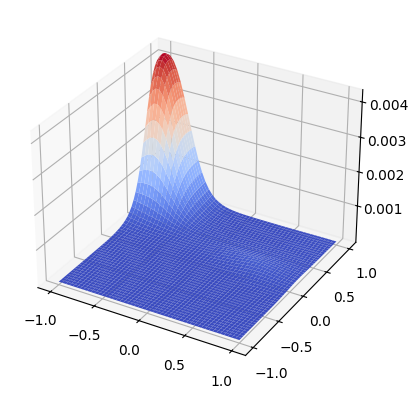

In [55]:
batch = dataset[457]
label0, coords1, coords2, results = visualize(
    batch, 
    model, 
    cfg["grid_dim"], 
    cfg["batch_size"], 
    scale=cfg["scale"], 
    criterion=criterion,
    device=device,
    plot_type ='Acc'
)

print(label0)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
X, Y = np.meshgrid(coords1, coords2)
ax.plot_surface(X, Y, results, cmap=cm.coolwarm)
#ax.set_zticks(np.arange(0.0025, 0.01, 0.0050))

In [56]:
np.argmin(results[25, :])

tensor(17)

tensor(1.)


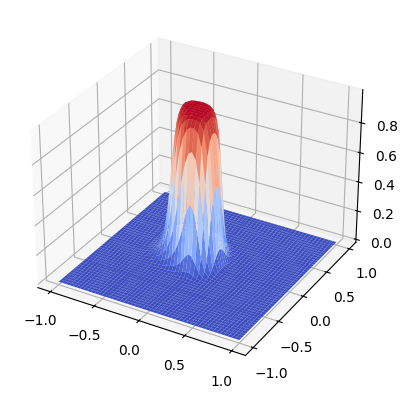

In [57]:
batch = dataset[11]
label0, coords1, coords2, results = visualize(
    batch, 
    model, 
    cfg["grid_dim"], 
    cfg["batch_size"], 
    scale=cfg["scale"], 
    criterion=criterion,
    device=device,
    plot_type ='Acc'
)

print(label0)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
X, Y = np.meshgrid(coords1, coords2)
ax.plot_surface(X, Y, results, cmap=cm.coolwarm)

In [50]:
results[25][25]

tensor(0.5370)